# CSV file before and after datasets

In [7]:
#this is where the real shit begins

# Cleaning excel sheet and create csv file

In [1]:
import pandas as pd
import os

file_path = os.path.join(os.getcwd(), "fault_data_inv.xlsx")
df = pd.read_excel(file_path, engine='openpyxl')

# set column names
df.columns = df.iloc[0]
df = df[1:].reset_index(drop=True)  # dont take the first row

# save as csv
csv_path = "initial_fault_data.csv"
df.to_csv(csv_path, index=False)

print(f"CSV saved at: {csv_path}")


CSV saved at: initial_fault_data.csv


# cleaning csv file

In [2]:
import pandas as pd

csv_path = "initial_fault_data.csv"
df = pd.read_csv(csv_path)

print(df.head())

# remove values with no change
df_cleaned = df[df.iloc[:, 2:].nunique(axis=1) > 1]

# cleaned csv
cleaned_csv_path = "cleaned_fault_data.csv"
df_cleaned.to_csv(cleaned_csv_path, index=False)

print(f"Cleaned CSV saved at: {cleaned_csv_path}")


  Present Date: 01/01/2025 17:44:22 Unnamed: 1           Unnamed: 2  \
0                               NaN        NaN                  NaN   
1                        Field Name      Units  2024-11-19 07:46:00   
2                      Packet_Index        NaN                    0   
3                        Loco_speed       KMPH                   56   
4                      Acceleration     m/sec2                 -0.3   

            Unnamed: 3           Unnamed: 4           Unnamed: 5  \
0                  NaN                  NaN                  NaN   
1  2024-11-19 07:46:01  2024-11-19 07:46:02  2024-11-19 07:46:03   
2                    0                    0                    0   
3                   55                   54                   53   
4                 -0.3                 -0.3                 -0.2   

            Unnamed: 6           Unnamed: 7           Unnamed: 8  \
0                  NaN                  NaN                  NaN   
1  2024-11-19 07:46:04  2024

# getting mean values and a new csv file

In [3]:
import pandas as pd

df = pd.read_csv('cleaned_fault_data.csv')

# strip whitespace
df.columns = df.columns.str.strip()

# errors='coerce' will turn non-numeric values into NaN
df.iloc[:, 2:] = df.iloc[:, 2:].apply(pd.to_numeric, errors='coerce')

# mean values before fault (columns C to G)
df['Mean_Before_Fault'] = df.iloc[:, 2:7].mean(axis=1)

# mean values after fault (columns H to L)
df['Mean_After_Fault'] = df.iloc[:, 7:12].mean(axis=1)

# new data
mean_df = df.iloc[:, [0, 1]].copy()
mean_df['Mean_Before_Fault'] = df['Mean_Before_Fault']
mean_df['Mean_After_Fault'] = df['Mean_After_Fault']

# replace NaN values with N/A cause i like it
mean_df = mean_df.fillna("N/A")

# mean values csv
mean_df.to_csv('mean_values.csv', index=False)

# just to see
print(mean_df)


    Present Date: 01/01/2025 17:44:22 Unnamed: 1 Mean_Before_Fault  \
0                          Field Name      Units               N/A   
1                        Packet_Index        N/A               0.0   
2                          Loco_speed       KMPH              54.0   
3                        Acceleration     m/sec2             -0.26   
4                         OHE_Volt_KV         KV             27.54   
..                                ...        ...               ...   
136                    LC4_DCL_EFlt_V      Volts           1752.14   
137           LC4__Is_Rms_With_Ripple       Amps              4.44   
138                      LC4_DCLV_Max      Volts            2365.0   
139                    LC4_PLL_Ph_Err        deg            -0.004   
140                       Fault_Count        NUM              12.0   

    Mean_After_Fault  
0                N/A  
1                2.0  
2               51.2  
3              -0.18  
4               27.6  
..               ... 

# sort mean_values csv

In [4]:
import pandas as pd

df = pd.read_csv('mean_values.csv')

df.columns = df.columns.str.strip()

df[['Mean_Before_Fault', 'Mean_After_Fault']] = df[['Mean_Before_Fault', 'Mean_After_Fault']].replace("N/A", pd.NA)
df[['Mean_Before_Fault', 'Mean_After_Fault']] = df[['Mean_Before_Fault', 'Mean_After_Fault']].apply(pd.to_numeric, errors='coerce')

# normal changes
df['Change_Type'] = 'Normal Change'
df.loc[(df['Mean_Before_Fault'] == 0) & (df['Mean_After_Fault'] != 0), 'Change_Type'] = 'Zero to Non-Zero Change'

df['Absolute_Percentage_Change'] = abs((df['Mean_After_Fault'] - df['Mean_Before_Fault']) / df['Mean_Before_Fault']) * 100
df.loc[df['Change_Type'] == 'Zero to Non-Zero Change', 'Absolute_Percentage_Change'] = float('inf')

zero_to_non_zero_df = df[df['Change_Type'] == 'Zero to Non-Zero Change']

normal_change_df = df[df['Change_Type'] != 'Zero to Non-Zero Change']

# absolute change
normal_change_df = normal_change_df.sort_values(by='Absolute_Percentage_Change', ascending=False)

# sort data
sorted_df = pd.concat([zero_to_non_zero_df, normal_change_df], ignore_index=True)

sorted_df = sorted_df.fillna("N/A")

sorted_df.to_csv('mean_values_sorted.csv', index=False)

print(sorted_df)


    Present Date: 01/01/2025 17:44:22 Unnamed: 1 Mean_Before_Fault  \
0                        Packet_Index        N/A               0.0   
1                AC2_Output_Frequency         Hz               0.0   
2                AC3_Output_Frequency         Hz               0.0   
3                      AC3_RY_Ph_Volt      Volts               0.0   
4                      AC3_YB_Ph_Volt      Volts               0.0   
..                                ...        ...               ...   
136                     VCU2_DOP_Temp      Deg c              24.4   
137                     VCU1_DIP_Temp      Deg c              23.8   
138                         LC2_OVL_I       Amps              0.82   
139                         LC4_OVL_I       Amps               1.0   
140                        Field Name      Units               N/A   

    Mean_After_Fault              Change_Type Absolute_Percentage_Change  
0                2.0  Zero to Non-Zero Change                        inf  
1        

# time to plot a bar graph to see freaking differences

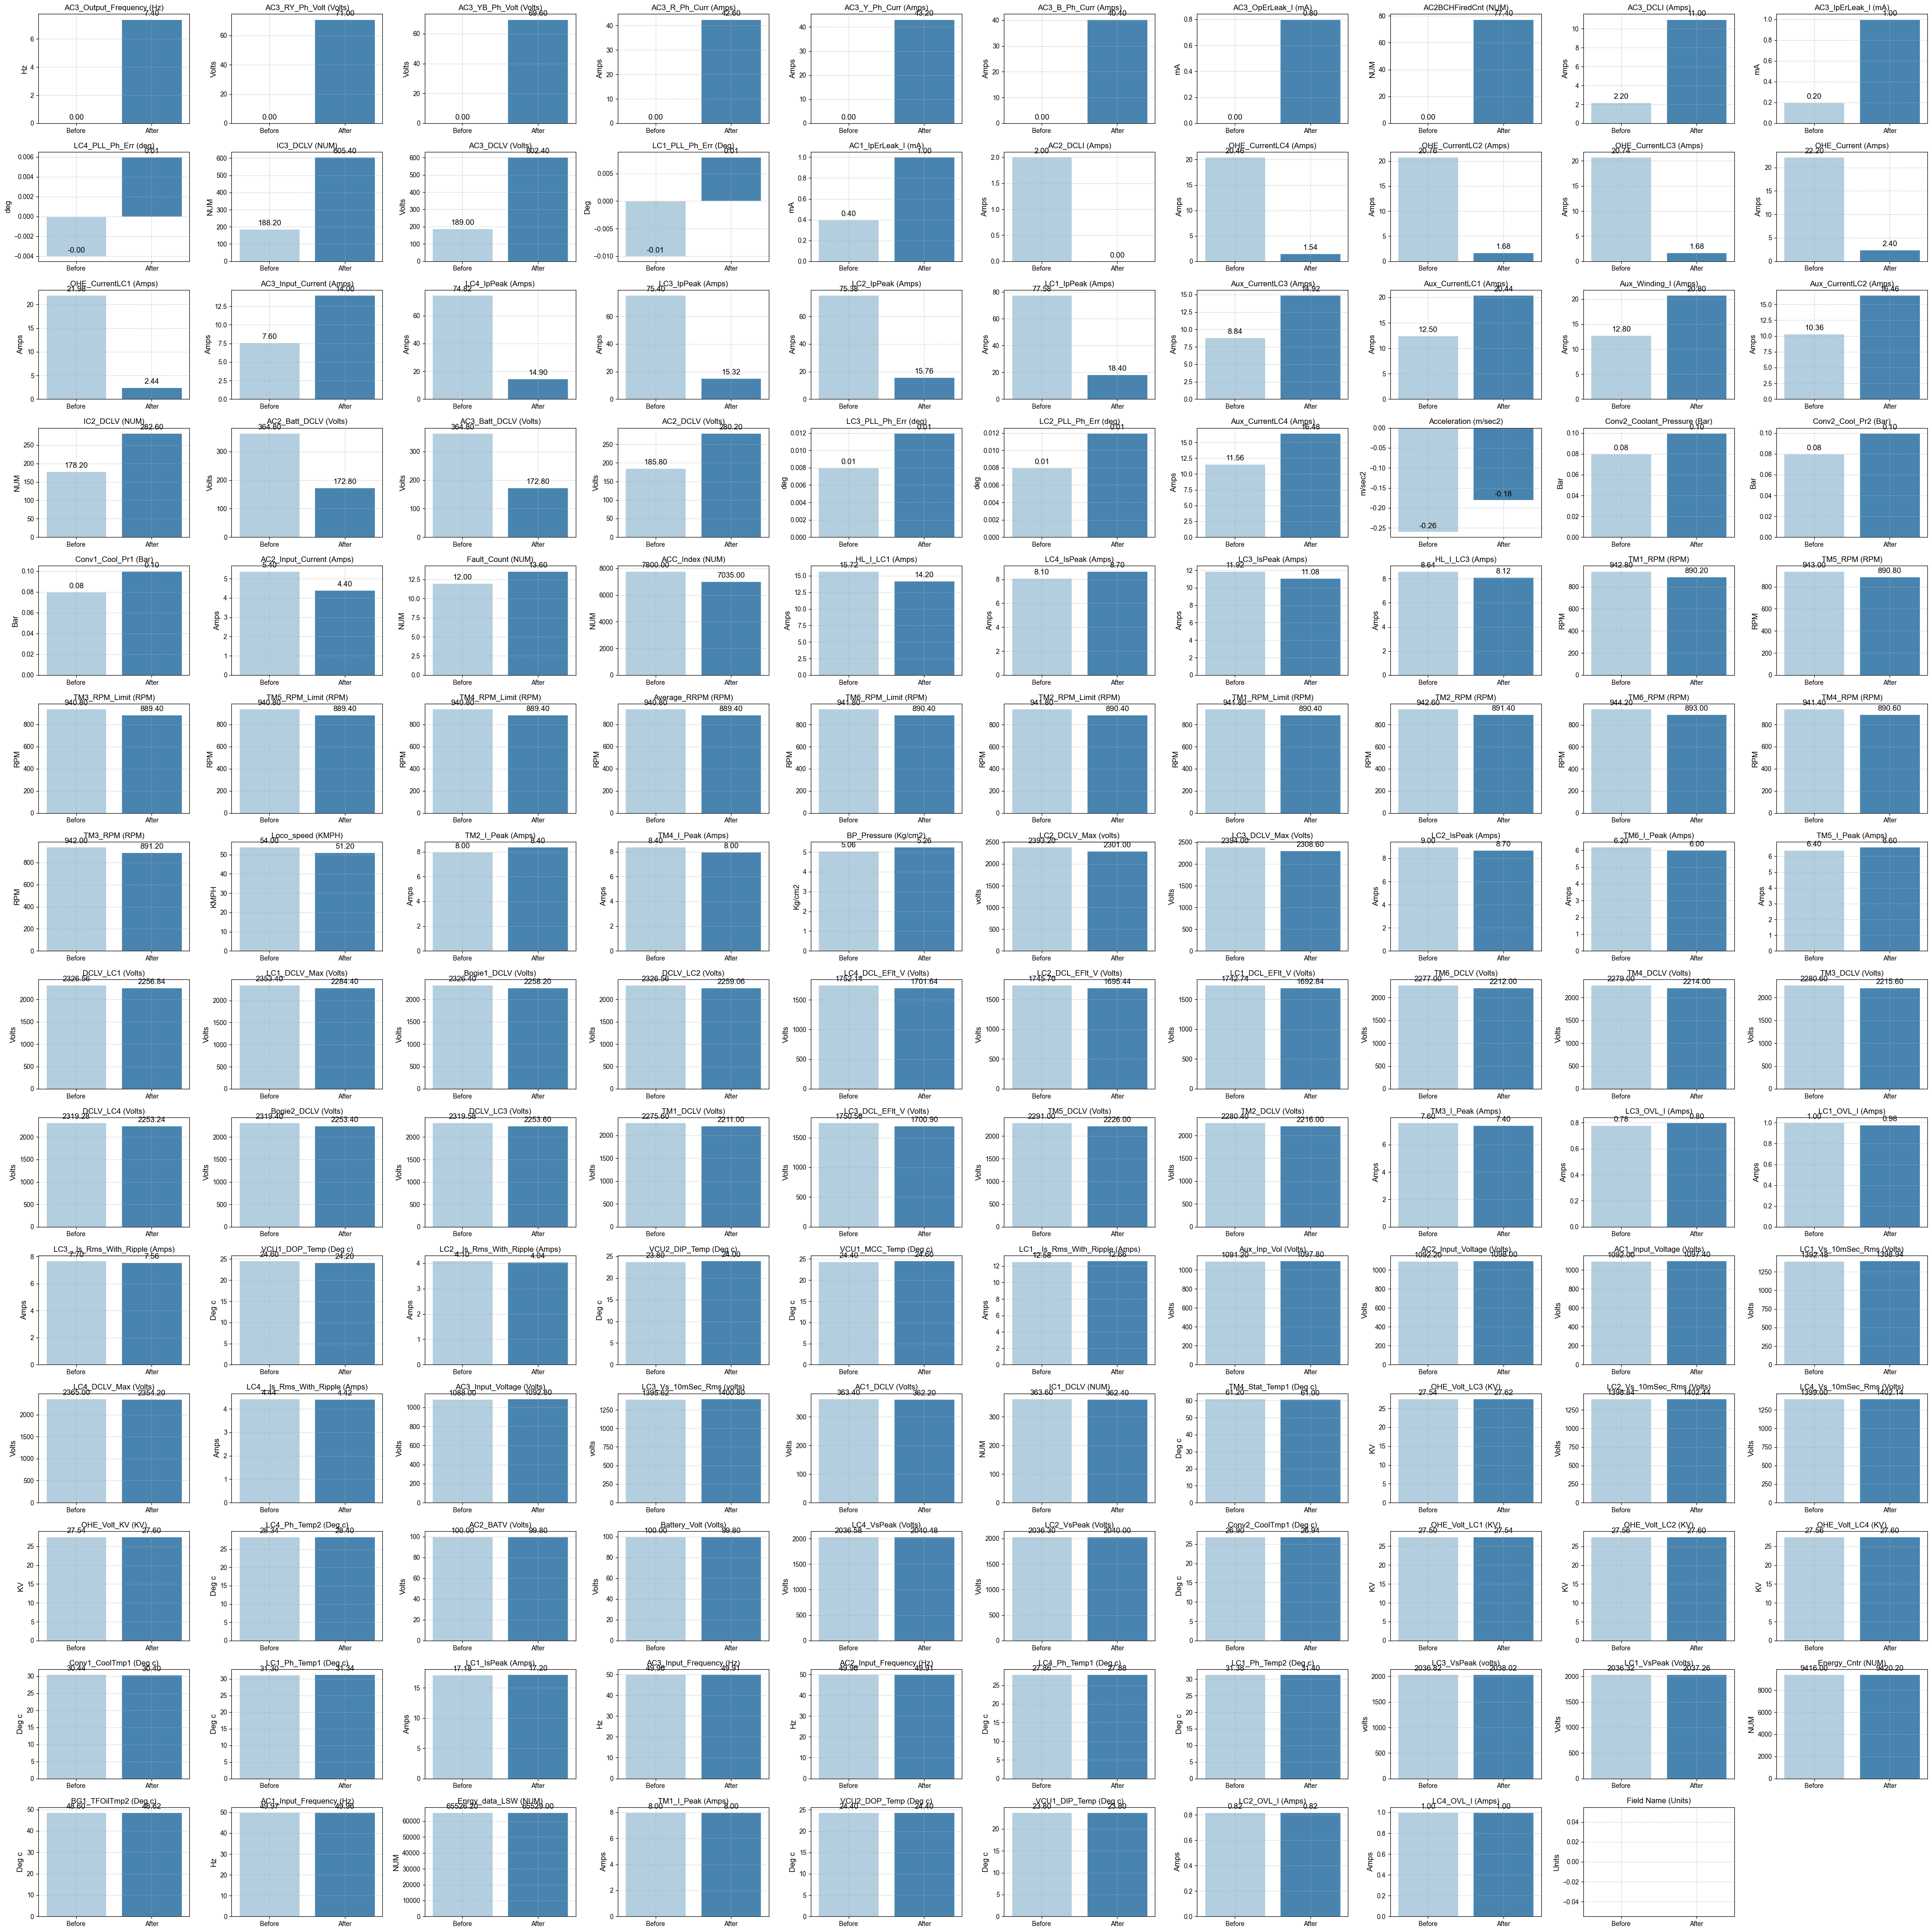

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('mean_values_sorted.csv')
df.columns = df.columns.str.strip()

num_cols = 10  
num_rows = (len(df.iloc[2:]) // num_cols) + 1  


aspect_ratio = max(num_rows, num_cols)


fig, axes = plt.subplots(num_rows, num_cols, figsize=(aspect_ratio * 3, aspect_ratio * 3))
fig.tight_layout(pad=5.0)
axes = axes.flatten()

for idx, (index, row) in enumerate(df.iloc[2:].iterrows()):
    field_name = row.iloc[0]
    unit = row.iloc[1]
    mean_before = row.iloc[2]
    mean_after = row.iloc[3]
    
    data = {
        'Field Name': ['Before', 'After'],
        'Mean Value': [mean_before, mean_after]
    }
    
    plot_df = pd.DataFrame(data)
    
    ax = axes[idx]
    
    sns.set_theme(style="whitegrid")
    sns.barplot(data=plot_df, x='Field Name', y='Mean Value', hue='Field Name', palette='Blues', ax=ax, legend=False)
    
    ax.set_title(f"{field_name} ({unit})", fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel(f'{unit}', fontsize=12)
    
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    fontsize=12, color='black', 
                    xytext=(0, 9), textcoords='offset points')
    
    ax.set_xticks([0, 1])
    ax.grid(True, linestyle='--', alpha=0.6)

for idx in range(len(df.iloc[2:]), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


# plot fix

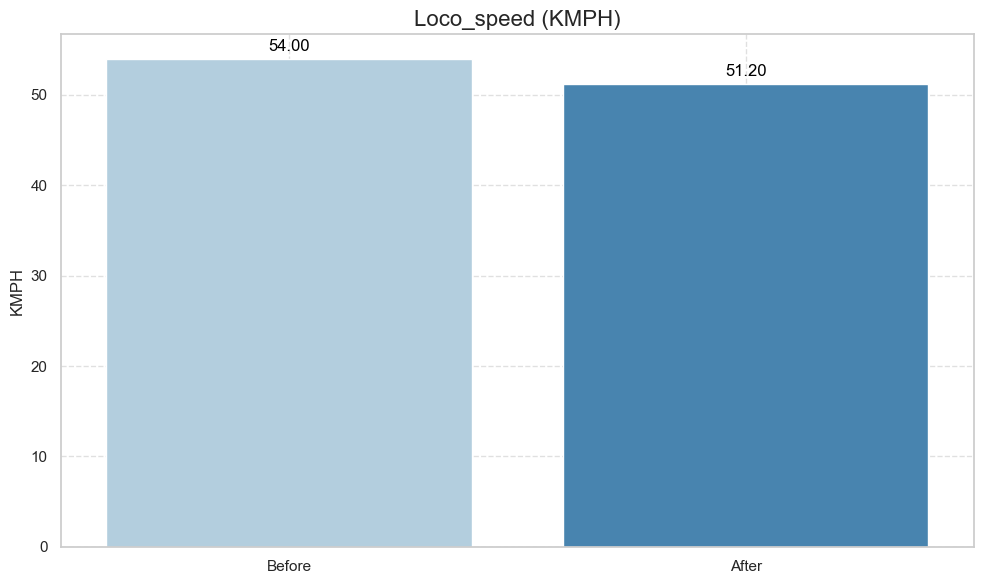

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('mean_values.csv')

df.columns = df.columns.str.strip()

row = df.iloc[2] 

field_name = row.iloc[0]  
unit = row.iloc[1]  
mean_before = row.iloc[2]  
mean_after = row.iloc[3]  

data = {
    'Field Name': [f"Before", f"After"],  # x-axis
    'Mean Value': [mean_before, mean_after]
}
plot_df = pd.DataFrame(data)

# plot size
plt.figure(figsize=(10, 6))

sns.set_theme(style="whitegrid")
ax = sns.barplot(data=plot_df, x='Field Name', y='Mean Value', hue='Field Name', palette='Blues', legend=False)

# title and axis labels
ax.set_title(f"{field_name} ({unit})", fontsize=16)
ax.set_xlabel('')  # remove the x-axis title
ax.set_ylabel(f'{unit}', fontsize=12)


for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 9), textcoords='offset points')


ax.set_xticks([0, 1])

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()
